In [77]:
import numpy as np
import scipy.stats as stats
##Library neural nets
from keras import losses
from keras.models import Sequential
from keras.layers import Dense, Dropout,BatchNormalization
from keras.optimizers import Adam
# Library for Gaussian process
import GPy
##Library for visualization
import matplotlib as mpl
mpl.style.use("seaborn")
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib;matplotlib.rcParams['figure.figsize'] = (8,6)
import pylab

In [100]:
n = 50
N = 50 * 50
np.random.seed(123)
s_1 = np.linspace(0,1,50).reshape(-1,1)
s_2 = np.linspace(0,1,50).reshape(-1,1)
s_x,s_y=np.meshgrid(s_1,s_2)
s = np.vstack((s_x.flatten(),s_y.flatten())).T
pi = np.random.binomial(1,0.5,size=N)
y = 2 * np.sin( (s[:,0]+0.5)*(s[:,1] + 0.5)) * pi + (np.sin(s[:,0]*s[:,1]))*(1 - pi)
y = y + np.random.normal(0,0.2, size=N) * pi + (np.random.normal(0,0.2, size=N))*(1 - pi)
y = np.exp(y)
y = y.reshape(-1,1)

In [97]:
n = 50
N = 50 * 50
s_1 = np.linspace(0,1,50).reshape(-1,1)
s_2 = np.linspace(0,1,50).reshape(-1,1)
s_x,s_y=np.meshgrid(s_1,s_2)
s = np.vstack((s_x.flatten(),s_y.flatten())).T
kernel1 = GPy.kern.Exponential(2,3,0.2) ##Covariance Function
kernel2 = GPy.kern.Matern52(2,1,0.5) ##Covariance Function
cov_mat1 = kernel1.K(s)
cov_mat2 = kernel2.K(s)
# Generate M sample path with mean mu and covariance C
np.random.seed(123)
y1 = np.random.multivariate_normal(np.zeros(N),cov_mat1).T
y2 = np.random.multivariate_normal(np.ones(N),cov_mat2).T
pi = np.random.binomial(1,0.5,size=N)
y = y1 + y2*0.5
y = np.exp(y/3+1)
y = np.random.poisson(y)
y = y.reshape(-1,1)

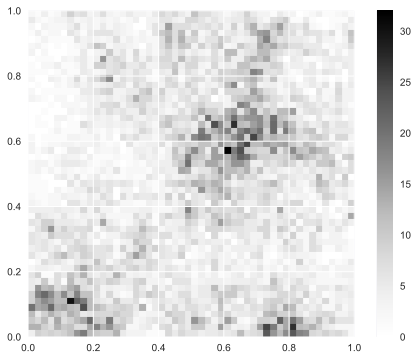

In [98]:
##Visualization of one replicate
y_mat = y.reshape(n,n)
fig, ax = plt.subplots()
im = ax.imshow(y_mat, extent=[0, 1, 0, 1], origin="lower",
               vmax=y_mat.max(), vmin=y_mat.min())
plt.colorbar(im)
plt.show()

In [107]:
def create_mlp(feature_dim):
    # create model
    model = Sequential()
    model.add(Dense(200, input_dim = feature_dim,  kernel_initializer='he_uniform', activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(1, activation='relu'))
    # Compile model
    model.compile(loss='poisson', optimizer='adam', metrics=['mse','mae'])
    return model

In [60]:
num_basis = [10**2,19**2,37**2,73**2]
knots_1dx = [np.linspace(0,1,np.sqrt(i)) for i in num_basis]
knots_1dy = [np.linspace(0,1,np.sqrt(i)) for i in num_basis]
##Wendland kernel
basis_size = 0
phi = np.zeros((N, sum(num_basis)))
for res in range(len(num_basis)):
    theta = 1/np.sqrt(num_basis[res])*2.5
    knots_x, knots_y = np.meshgrid(knots_1dx[res],knots_1dy[res])
    knots = np.column_stack((knots_x.flatten(),knots_y.flatten()))
    for i in range(num_basis[res]):
        d = np.linalg.norm(s-knots[i,:],axis=1)/theta
        for j in range(len(d)):
            if d[j] >= 0 and d[j] <= 1:
                phi[j,i + basis_size] = (1-d[j])**6 * (35 * d[j]**2 + 18 * d[j] + 3)/3
            else:
                phi[j,i + basis_size] = 0
    basis_size = basis_size + num_basis[res]

In [105]:
from sklearn.model_selection import train_test_split
indices = np.arange(N)
## Split the training and testing sets
s_train, s_test, phi_train, phi_test\
    , y_train, y_test, idx_train, idx_test \
    = train_test_split(s, phi, y, indices, test_size=0.2)
N_train = s_train.shape[0]
N_test = s_test.shape[0]

In [108]:
model = create_mlp(feature_dim = basis_size)
# train the model
print("[INFO] training model ...")
train_history = model.fit(phi_train, y_train, validation_split=0.2,epochs = 200, batch_size = 64, verbose = 1)

[INFO] training model ...
Train on 1600 samples, validate on 400 samples
Epoch 1/200
1600/1600 [==============================] - 2s 988us/step - loss: 11.2017 - mean_squared_error: 45.7115 - mean_absolute_error: 5.3425 - val_loss: 0.1841 - val_mean_squared_error: 43.6943 - val_mean_absolute_error: 4.8293
Epoch 2/200
1600/1600 [==============================] - 0s 275us/step - loss: -2.3002 - mean_squared_error: 28.3436 - mean_absolute_error: 3.7623 - val_loss: -4.4459 - val_mean_squared_error: 22.7539 - val_mean_absolute_error: 3.2600
Epoch 3/200
1600/1600 [==============================] - 0s 281us/step - loss: -4.4104 - mean_squared_error: 16.2170 - mean_absolute_error: 2.8636 - val_loss: -5.1425 - val_mean_squared_error: 15.0347 - val_mean_absolute_error: 2.8006
Epoch 4/200
1600/1600 [==============================] - 0s 273us/step - loss: -4.8687 - mean_squared_error: 11.3630 - mean_absolute_error: 2.3916 - val_loss: -5.3317 - val_mean_squared_error: 12.6610 - val_mean_absolute_er

1600/1600 [==============================] - 0s 293us/step - loss: -5.5479 - mean_squared_error: 2.8907 - mean_absolute_error: 1.1008 - val_loss: -5.0693 - val_mean_squared_error: 14.2036 - val_mean_absolute_error: 2.7741
Epoch 36/200
1600/1600 [==============================] - 1s 316us/step - loss: -5.5537 - mean_squared_error: 2.8637 - mean_absolute_error: 1.0868 - val_loss: -5.0629 - val_mean_squared_error: 14.3162 - val_mean_absolute_error: 2.7541
Epoch 37/200
1600/1600 [==============================] - 0s 288us/step - loss: -5.5576 - mean_squared_error: 2.6301 - mean_absolute_error: 1.0916 - val_loss: -5.0764 - val_mean_squared_error: 13.8979 - val_mean_absolute_error: 2.6871
Epoch 38/200
1600/1600 [==============================] - 0s 273us/step - loss: -5.5509 - mean_squared_error: 2.8638 - mean_absolute_error: 1.1090 - val_loss: -5.0808 - val_mean_squared_error: 14.3160 - val_mean_absolute_error: 2.7552
Epoch 39/200
1600/1600 [==============================] - 0s 275us/step -

Epoch 70/200
1600/1600 [==============================] - 0s 285us/step - loss: -5.5851 - mean_squared_error: 2.1747 - mean_absolute_error: 1.0078 - val_loss: -4.9035 - val_mean_squared_error: 14.4667 - val_mean_absolute_error: 2.7564
Epoch 71/200
1600/1600 [==============================] - 0s 282us/step - loss: -5.5819 - mean_squared_error: 2.2911 - mean_absolute_error: 1.0236 - val_loss: -4.8910 - val_mean_squared_error: 14.3997 - val_mean_absolute_error: 2.7314
Epoch 72/200
1600/1600 [==============================] - 0s 274us/step - loss: -5.5798 - mean_squared_error: 2.3788 - mean_absolute_error: 1.0100 - val_loss: -4.9372 - val_mean_squared_error: 14.1176 - val_mean_absolute_error: 2.7134
Epoch 73/200
1600/1600 [==============================] - 0s 272us/step - loss: -5.5865 - mean_squared_error: 2.1846 - mean_absolute_error: 1.0110 - val_loss: -4.9317 - val_mean_squared_error: 13.9866 - val_mean_absolute_error: 2.7115
Epoch 74/200
1600/1600 [==============================] - 0s

Epoch 105/200
1600/1600 [==============================] - 0s 273us/step - loss: -5.5884 - mean_squared_error: 2.4024 - mean_absolute_error: 1.0036 - val_loss: -4.8855 - val_mean_squared_error: 13.9152 - val_mean_absolute_error: 2.6820
Epoch 106/200
1600/1600 [==============================] - 0s 272us/step - loss: -5.5906 - mean_squared_error: 2.1533 - mean_absolute_error: 0.9664 - val_loss: -4.9080 - val_mean_squared_error: 13.8844 - val_mean_absolute_error: 2.6991
Epoch 107/200
1600/1600 [==============================] - 0s 281us/step - loss: -5.5847 - mean_squared_error: 2.3087 - mean_absolute_error: 1.0260 - val_loss: -4.9154 - val_mean_squared_error: 13.7202 - val_mean_absolute_error: 2.7042
Epoch 108/200
1600/1600 [==============================] - 0s 291us/step - loss: -5.5855 - mean_squared_error: 2.4296 - mean_absolute_error: 0.9935 - val_loss: -4.8923 - val_mean_squared_error: 13.7272 - val_mean_absolute_error: 2.6913
Epoch 109/200
1600/1600 [==============================]

Epoch 140/200
1600/1600 [==============================] - 1s 327us/step - loss: -5.5963 - mean_squared_error: 2.1215 - mean_absolute_error: 0.9611 - val_loss: -4.8694 - val_mean_squared_error: 14.2288 - val_mean_absolute_error: 2.7221
Epoch 141/200
1600/1600 [==============================] - 0s 303us/step - loss: -5.5962 - mean_squared_error: 2.2353 - mean_absolute_error: 0.9693 - val_loss: -4.8627 - val_mean_squared_error: 13.8808 - val_mean_absolute_error: 2.6716
Epoch 142/200
1600/1600 [==============================] - 0s 290us/step - loss: -5.5946 - mean_squared_error: 2.2075 - mean_absolute_error: 0.9750 - val_loss: -4.8587 - val_mean_squared_error: 14.3072 - val_mean_absolute_error: 2.7404
Epoch 143/200
1600/1600 [==============================] - 0s 284us/step - loss: -5.6035 - mean_squared_error: 1.9677 - mean_absolute_error: 0.9370 - val_loss: -4.8410 - val_mean_squared_error: 14.0738 - val_mean_absolute_error: 2.7213
Epoch 144/200
1600/1600 [==============================]

Epoch 175/200
1600/1600 [==============================] - 0s 258us/step - loss: -5.6170 - mean_squared_error: 1.7075 - mean_absolute_error: 0.8690 - val_loss: -4.8527 - val_mean_squared_error: 14.3655 - val_mean_absolute_error: 2.7352
Epoch 176/200
1600/1600 [==============================] - 0s 254us/step - loss: -5.6013 - mean_squared_error: 2.2740 - mean_absolute_error: 0.9713 - val_loss: -4.8348 - val_mean_squared_error: 14.0720 - val_mean_absolute_error: 2.6917
Epoch 177/200
1600/1600 [==============================] - 0s 258us/step - loss: -5.6082 - mean_squared_error: 1.9691 - mean_absolute_error: 0.9212 - val_loss: -4.8484 - val_mean_squared_error: 14.0523 - val_mean_absolute_error: 2.7084
Epoch 178/200
1600/1600 [==============================] - 0s 254us/step - loss: -5.6047 - mean_squared_error: 2.0559 - mean_absolute_error: 0.9297 - val_loss: -4.9003 - val_mean_squared_error: 13.8334 - val_mean_absolute_error: 2.6977
Epoch 179/200
1600/1600 [==============================]

In [109]:
kernel = GPy.kern.Exponential(2,1,1) ##Covariance Function
m = GPy.models.GPRegression(s_train,y_train, kernel, noise_var = 0.01)
m.optimize()
mu_GP,var_GP = m.predict(s)
lo95_GP,up95_GP = m.predict_quantiles(s)
y_gp = mu_GP

In [110]:
y_dk_test = model.predict(phi_test)
y_gp_test,var_GP = m.predict(s_test)

In [118]:
losses.poisson(y_test,y_gp_test)

<tf.Tensor 'Mean_5:0' shape=(500,) dtype=float64>

In [119]:
print(rmse(y_test,y_gp_test))
print(mae(y_test,y_gp_test))

2.8102466657660887
2.114942879407305


In [121]:
y_dk_test

array([[ 4.641679  ],
       [ 8.183272  ],
       [ 0.888913  ],
       [ 1.3070372 ],
       [ 2.0395517 ],
       [ 2.7341967 ],
       [ 3.9285665 ],
       [ 6.0976677 ],
       [ 6.4372454 ],
       [ 7.8218913 ],
       [ 7.2284555 ],
       [ 1.4167442 ],
       [ 2.9338782 ],
       [ 1.5945358 ],
       [ 1.5052512 ],
       [ 6.1844964 ],
       [ 6.873173  ],
       [ 7.039379  ],
       [12.628346  ],
       [ 4.275649  ],
       [ 3.153999  ],
       [ 2.6694262 ],
       [ 8.878307  ],
       [ 3.3397274 ],
       [ 5.907754  ],
       [ 7.074596  ],
       [ 2.5509088 ],
       [15.236084  ],
       [ 2.2583096 ],
       [ 8.405245  ],
       [ 3.9670348 ],
       [12.629796  ],
       [ 0.        ],
       [ 0.23912969],
       [ 7.486211  ],
       [ 3.6249442 ],
       [ 3.4509654 ],
       [ 7.699238  ],
       [ 7.796187  ],
       [ 7.0122175 ],
       [ 4.7481403 ],
       [ 6.0605564 ],
       [ 8.021765  ],
       [ 1.3257079 ],
       [ 3.581644  ],
       [ 3

In [122]:
y_test

array([[ 6],
       [ 9],
       [ 2],
       [ 1],
       [ 3],
       [ 3],
       [ 5],
       [ 7],
       [ 5],
       [ 8],
       [ 8],
       [ 6],
       [ 4],
       [ 1],
       [ 9],
       [13],
       [ 2],
       [ 7],
       [22],
       [ 4],
       [ 4],
       [ 5],
       [ 5],
       [ 5],
       [ 2],
       [ 8],
       [ 5],
       [10],
       [ 1],
       [ 7],
       [ 0],
       [11],
       [ 1],
       [ 2],
       [11],
       [ 4],
       [ 3],
       [ 4],
       [11],
       [ 8],
       [ 8],
       [ 7],
       [ 7],
       [ 1],
       [ 7],
       [ 4],
       [ 2],
       [ 2],
       [ 5],
       [ 5],
       [ 0],
       [12],
       [13],
       [ 3],
       [ 4],
       [ 2],
       [ 5],
       [ 4],
       [ 5],
       [ 4],
       [ 2],
       [17],
       [ 3],
       [ 3],
       [ 3],
       [ 2],
       [ 2],
       [ 7],
       [ 4],
       [ 8],
       [ 2],
       [ 7],
       [ 7],
       [ 8],
       [ 3],
       [ 6],
       [ 1],

In [120]:
print(rmse(y_test,y_dk_test))
print(mae(y_test,y_dk_test))

3.2504425489821824
2.4593691779971123


## Density estimation

In [51]:
import sys
sys.path.append('../')
from dcdr.deep_hist import Binning_CDF

In [26]:
sum(phi[:,1828]!=0)

17

In [300]:
from scipy.stats import iqr
init_seed = 1
bin_width = 2 * iqr(z_train)/(N**(1/3))
num_cut = int((z_train.max()-z_train.min())/bin_width)
hidden_list = [100,100,100]
dropout_list = [0.5,0.5,0.5]
histogram_bin = 'fixed'
loss_model = 'multi-binary'
seeding = 2

In [301]:
print(num_cut)

18


In [305]:
dcdr_model = Binning_CDF(num_cut=num_cut*10, hidden_list=hidden_list,
                         histogram_bin=histogram_bin, dropout_list=dropout_list,
                         seeding=seeding, loss_model=loss_model, 
                         niter=10)
    
dcdr_model.fit_cdf(XRBF_train, z_train, batch_size=32, merge_empty_bin=True, epochs = 500)

Train on 1920 samples, validate on 480 samples
Epoch 1/500
1920/1920 [==============================] - 12s 6ms/step - loss: 0.4307 - acc: 0.7858 - val_loss: 0.3575 - val_acc: 0.8584
Epoch 2/500
1920/1920 [==============================] - 0s 258us/step - loss: 0.3669 - acc: 0.8338 - val_loss: 0.2819 - val_acc: 0.8842
Epoch 3/500
1920/1920 [==============================] - 0s 250us/step - loss: 0.3151 - acc: 0.8661 - val_loss: 0.2479 - val_acc: 0.8863
Epoch 4/500
1920/1920 [==============================] - 0s 259us/step - loss: 0.2916 - acc: 0.8720 - val_loss: 0.2378 - val_acc: 0.8894
Epoch 5/500
1920/1920 [==============================] - 0s 259us/step - loss: 0.2798 - acc: 0.8785 - val_loss: 0.2348 - val_acc: 0.8891
Epoch 6/500
1920/1920 [==============================] - 1s 261us/step - loss: 0.2727 - acc: 0.8793 - val_loss: 0.2324 - val_acc: 0.8889
Epoch 7/500
1920/1920 [==============================] - 0s 258us/step - loss: 0.2702 - acc: 0.8787 - val_loss: 0.2321 - val_acc: 0.

In [310]:
up95_dpk=dcdr_model.predict_quantile(XRBF,quantiles=0.975)
lo95_dpk=dcdr_model.predict_quantile(XRBF,quantiles=0.025)

In [291]:
def density_func3(X, grid):  
    from scipy.stats import norm
    
    loc1 = np.sin(5* X[0] + 0.7)
    scale1 = 0.2
    
    loc2 = np.sin(8 * X[0])
    scale2 = 0.3
    
    rv1 = norm(loc=loc1, scale=scale1)
    rv2 = norm(loc=loc2, scale=scale2)
    return rv1.pdf(grid)*0.5 + rv2.pdf(grid)*0.5

In [50]:
y_test

array([[ 0.98291073],
       [ 0.88948179],
       [ 0.23760553],
       [ 0.24730307],
       [ 0.71449592],
       [ 0.86218488],
       [ 0.9135364 ],
       [ 0.69829388],
       [ 0.90685547],
       [-0.34969091],
       [ 0.30892814],
       [ 0.99461786],
       [ 0.68513971],
       [ 0.99927422],
       [ 0.51927935],
       [ 0.88795426],
       [ 0.87355496],
       [-0.9865357 ],
       [ 0.28985389],
       [-0.71884244],
       [ 0.99780208],
       [ 0.7705053 ],
       [ 0.50784359],
       [ 0.76194155],
       [-0.64177304],
       [ 0.08652225],
       [-0.66198465],
       [ 0.41670801],
       [ 0.99691917],
       [ 0.99048485],
       [-0.37426606],
       [ 0.76347692],
       [ 0.30493568],
       [ 0.98229192],
       [ 0.71246365],
       [ 0.88331257],
       [ 0.78238465],
       [ 0.10267752],
       [ 0.98798818],
       [ 0.07323716],
       [ 0.90308754],
       [ 0.15352292],
       [ 0.86033593],
       [ 0.93185787],
       [ 0.19858769],
       [-0

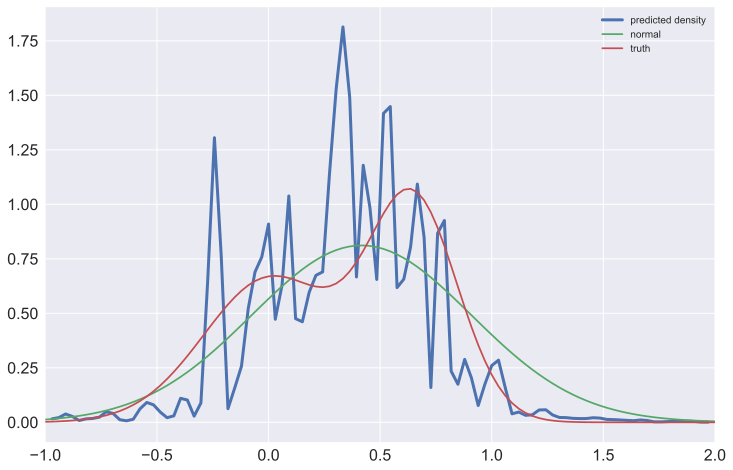

In [331]:
ref=1
grid = np.linspace(-1,2,100)
dcdr_model.plot_density(test_x = XRBF[ref,:],grid=grid)
pylab.plot(grid, stats.norm.pdf(grid, mu_GP[ref], np.sqrt(var_GP)[ref]),label="normal")
pylab.plot(grid, density_func3(s[ref],grid),label="truth")
pylab.legend(loc='best')
#pylab.show()
plt.savefig("density_sample.jpg")

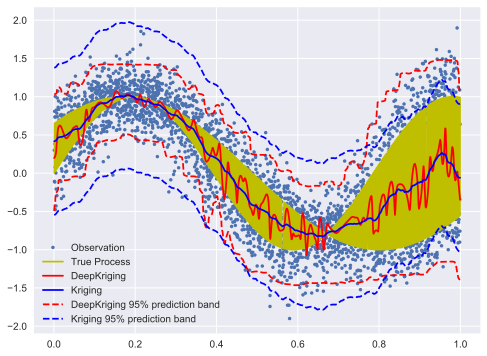

In [406]:
pylab.plot(s, z,".",label="Observation")
pylab.plot(s, y,"y",label="True Process")
pylab.plot(s, y_dk,'red',label="DeepKriging")
pylab.plot(s, mu_GP,'blue',label="Kriging")
plt.plot(s,up95_dpk,'r--',label="DeepKriging 95% prediction band")
plt.plot(s,lo95_dpk,'r--')
plt.plot(s,up95_GP,'b--',label="Kriging 95% prediction band")
plt.plot(s,lo95_GP,'b--')
#pylab.plot(s, mu+1,'black',label="GP")
pylab.legend(loc='best')
#pylab.show()
plt.savefig("1DMix_compare.pdf")

In [344]:
def Gaussian_CRPS(mu_test,sig_test,z_test):
    n = z_test.shape[0]
    crps = np.zeros(n)
    for i in range(n):
        pdf = stats.norm.pdf(z_test[i],loc=mu_test[i], scale=sig_test[i])
        cdf = stats.norm.cdf(z_test[i],loc=mu_test[i], scale=sig_test[i])
        scale_z = (z_test[i]-mu_test[i])/sig_test[i]
        crps[i] = sig_test[i]*(1/np.sqrt(np.pi)*2*pdf - scale_z*(2*cdf-1)
    return np.mean(crps)

In [345]:
z_test.shape

(600, 1)

In [415]:
XRBF_test = np.hstack((X_test,phi_test))
mu_GP_test,var_GP_test = m.predict(s_test)
dk_crps = dcdr_model.evaluate(XRBF_test, z_test, mode='CRPS')
Kriging_crps = Gaussian_CRPS(mu_GP_test,np.sqrt(var_GP),z_test)
quantiles = np.linspace(0.01, 0.99, num=99)
dcdr_aqtl = dcdr_model.evaluate(XRBF_test, z_test, quantiles=quantiles, mode='QuantileLoss')  

In [350]:
dk_crps

0.06022528843081059

In [351]:
Kriging_crps

0.06050130466399175

In [416]:
dcdr_aqtl

0.18754824844259477

In [403]:
def Gaussian_AQTL(s_test,z_test,quantiles):
    tau = quantiles.shape[0]
    aqtl = np.zeros(tau)
    for t in range(tau):
        aqtl[t] =np.mean((z_test -  m.predict_quantiles(s_test,quantiles[t:t+1])[0])*\
            (t- (z_test <=  m.predict_quantiles(s_test,quantiles[t:t+1])[0]))[0])    
    return np.mean(aqtl)

In [417]:
kriging_aqtl = Gaussian_AQTL(s_test, z_test, quantiles=quantiles)  

In [418]:
kriging_aqtl

61.71335578575979